In [1]:
import ipywidgets as widgets
import sys
from pathlib import Path
import os
import importlib


module_path='preprocessing/day_intervals_preproc'
if module_path not in sys.path:
    sys.path.append(module_path)

module_path='utils'
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path='preprocessing/hosp_module_preproc'
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path='model'
if module_path not in sys.path:
    sys.path.append(module_path)
#print(sys.path)
root_dir = os.path.dirname(os.path.abspath('UserInterface.ipynb'))
data_dir = '/datasets/MIMIC-IV/physionet.org/files'
import day_intervals_cohort
from day_intervals_cohort import *

import day_intervals_cohort_v2
from day_intervals_cohort_v2 import *

import data_generation_icu

import data_generation
import evaluation

import feature_selection_hosp
from feature_selection_hosp import *

# import train
# from train import *


import ml_models
from ml_models import *

import dl_train
from dl_train import *

import tokenization
from tokenization import *


import behrt_train
from behrt_train import *

import feature_selection_icu
from feature_selection_icu import *
import fairness
import callibrate_output

/fs01/home/chloexq/.cache/pypoetry/virtualenvs/time-series-library-UC7OlRP4-py3.8/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
%load_ext autoreload
%autoreload 2

importlib.reload(day_intervals_cohort)
import day_intervals_cohort
from day_intervals_cohort import *

importlib.reload(day_intervals_cohort_v2)
import day_intervals_cohort_v2
from day_intervals_cohort_v2 import *

importlib.reload(data_generation_icu)
import data_generation_icu
importlib.reload(data_generation)
import data_generation

importlib.reload(feature_selection_hosp)
import feature_selection_hosp
from feature_selection_hosp import *

importlib.reload(feature_selection_icu)
import feature_selection_icu
from feature_selection_icu import *

importlib.reload(tokenization)
import tokenization
from tokenization import *

importlib.reload(ml_models)
import ml_models
from ml_models import *

importlib.reload(dl_train)
import dl_train
from dl_train import *

importlib.reload(behrt_train)
import behrt_train
from behrt_train import *

importlib.reload(fairness)
import fairness

importlib.reload(callibrate_output)
import callibrate_output

importlib.reload(evaluation)
import evaluation

In [3]:
def set_seed(seed):
    """set random seed."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# Welcome to your MIMIC-IV Project

## 10. Running BEHRT
Below we integrate the implementation of BEHRT in our pipeline.
We perform pre-procesing needed to run BEHRT model. https://github.com/deepmedicine/BEHRT

Few things to note before running BEHRT -
- The numerical values are binned into quantiles.
- BEHRT has recommended maximum number of events per sample to be 512. 
    So feature selection is important so that number of events per sample does not exceed 512.
- The model is quite computationally heavy so it requires a GPU.

The output files for BEHRT will be saved in ./data/behrt/ folder

**Please run below cell to to pre-process and run BEHRT on the selected cohort**

In [4]:
importlib.reload(tokenization)
import tokenization
from tokenization import *

import behrt_train
from behrt_train import *

In [5]:
data_icu = True
diag_flag = True
proc_flag = False
out_flag = False
chart_flag = True
med_flag = True

In [6]:
if data_icu:
    token=tokenization.BEHRT_models(data_icu,diag_flag,proc_flag,out_flag,chart_flag,med_flag,False)
    #tokenized_src, tokenized_age, tokenized_gender, tokenized_ethni, tokenized_ins, tokenized_labels, labs, meds, meds_labels, n_meds =token.tokenize()
    #data2_dir = '/datasets/MIMIC-IV/'
    data2_dir = '/h/chloexq/los-prediction/pipeline/data/features/'
    n_meds = 270
    names = ['tokenized_src', 'tokenized_age', 'tokenized_gender', 'tokenized_ethni', 'tokenized_ins', 'tokenized_labels', 'labs', 'meds']
    #meds_labels = np.load(data2_dir + 'data/token/'+'meds_labels_5000.npy', allow_pickle=True)
    meds_labels = np.load(data2_dir + 'meds_labels_5000.npy', allow_pickle=True)
    all_df = []
    for i in range(len(names)):
        #df = pd.read_csv(data2_dir + 'data/token/'+names[i]+'_5000.csv', index_col=0)
        df = pd.read_csv(data2_dir + names[i]+'_5000.csv', index_col=0)
        all_df.append(df)
    tokenized_src, tokenized_age, tokenized_gender, tokenized_ethni, tokenized_ins, tokenized_labels, labs, meds = all_df

In [7]:
model_config = {
    'vocab_size': int(tokenized_src.max().max() + 1), # number of disease + symbols for word embedding
    'hidden_size': 288, # word embedding and seg embedding hidden size
    'seg_vocab_size': 2, # number of vocab for seg embedding
    'age_vocab_size': int(tokenized_age.max().max() + 1), # number of vocab for age embedding
    'gender_vocab_size': 2 + 1, # TODO: +1 for missing values
    'ethni_vocab_size': int(tokenized_ethni.max().max()) + 1,
    'ins_vocab_size': int(tokenized_ins.max().max()) + 1,
    'max_position_embedding': tokenized_src.shape[1], # maximum number of tokens
    'hidden_dropout_prob': 0.2, # dropout rate
    'num_hidden_layers': 6, # number of multi-head attention layers required
    'num_attention_heads': 6, # number of attention heads
    'attention_probs_dropout_prob': 0.2, # multi-head attention dropout rate
    'intermediate_size': 256, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
    'number_output' : 2,
    'number_meds': n_meds,
}

In [8]:
# No need to reload model if just doing eval on saved predictions
# conf = BertConfig(model_config)
# behrt = BertForEHRPrediction(conf, model_config['number_output'])
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# behrt.load_state_dict(torch.load("./saved_models/checkpoint/DAB_1/behrt", map_location=device))

### EVALUATION AS STANDALONE MODULE
Below cell shows an exaple of how evaluation module can be used as a standalone module.

evaluation.Loss class can be instantiated and model output and ground truth can be passed to it to obtain results.

In the example below we captured model output and ground truth in a file and used that file to read the data.

In function definition ***loss(prob,truth,logits,False)***

prob -> List of Output predicted probabilities of case being positive

truth -> List of ground truth labels

logits -> List of logits obtained from last fully connected layer before applying softmax.sigmoid function in the model.

In [9]:
if torch.cuda.is_available():
    device='cuda:0'
#device='cpu'
loss=evaluation.Loss(device,acc=True,ppv=True,sensi=True,tnr=True,npv=True,auroc=True,aurocPlot=True,auprc=True,auprcPlot=True,callb=True,callbPlot=True)

In [10]:
logits = pd.read_csv('./data/behrt/full_model/behrt_preds.csv', index_col=0, header=None)

In [11]:
prob = torch.sigmoid(torch.tensor(logits.values)).numpy()
#prob = (prob-prob.min())/(prob.max()-prob.min())

In [12]:
truth = pd.read_csv('./data/behrt/full_model/behrt_labels.csv', index_col=0, header=None)

In [13]:
truth = truth.values.flatten().tolist()
logits = logits.values.flatten().tolist()
prob = prob.flatten().tolist()

AU-ROC score: 0.8
G-mean score:  0.67
positive accuracy 0.776 and len labels: 473
negative accuracy 0.572 and len labels: 533
BCE Loss: 1.35
AU-ROC: 0.80
AU-PRC: 0.77
AU-PRC Baaseline: 0.47
Accuracy: 0.67
Precision: 0.62
Recall: 0.78
Specificity: 0.57
NPV: 0.74
ECE: 0.20
MCE: 0.43
Cohen Koppa metric: 0.34


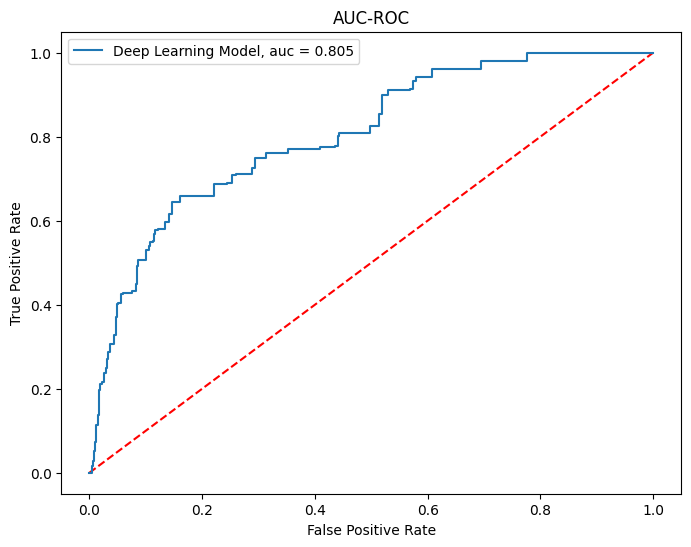

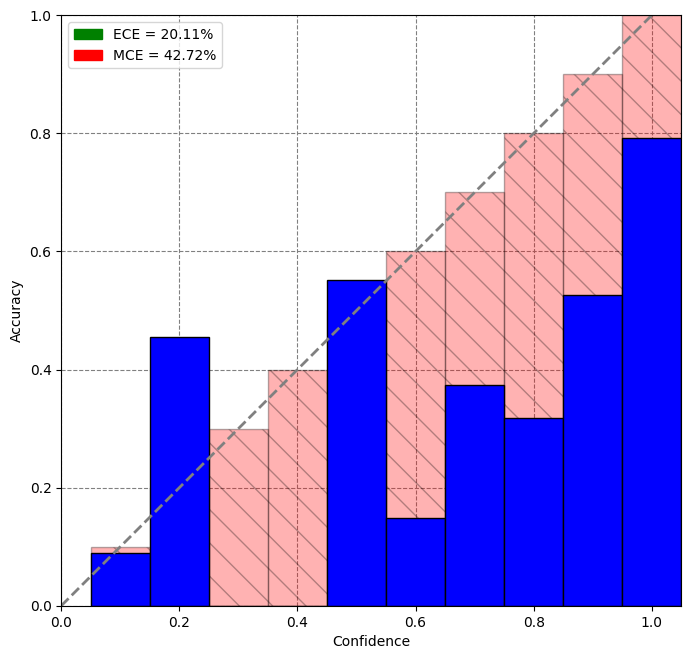

In [14]:
loss(prob,truth,logits,train=False,standalone=True)

In [15]:
output_df = pd.DataFrame()
output_df['Prob'] = prob
output_df['Logits'] = logits
output_df['Labels'] = truth

In [150]:
with open('./data/output/'+'outputDict_NODAB', 'wb') as fp:
    pickle.dump(output_df, fp)

In [74]:
# with open("./data/output/outputDict", 'rb') as fp:
#     outputDict=pickle.load(fp)
# prob=list(outputDict['Prob'])
# truth=list(outputDict['Labels'])
# logits=list(outputDict['Logits'])
# #print(torch.tensor(prob))
# print("======= TESTING ========")
# loss(prob,truth,logits,train=False,standalone=True)


### 11. FAIRNESS EVALUATION
In train and testing step we save output files in **./data/output/** folder.

This file conatins list of demographic variables included in training and testing of the model.

It also contains the ground truth labels and predicted probability for each sample.

We use the above saved data to perform fairness evaluation of the results obtained from model testing.

This module can be used as stand-alone module also.

Please create a file that contains predicted probabilites form the last sigmoid layer in column named **Prob** and
ground truth labels for each sample in column named **Labels**.

In [86]:
#fairness.fairness_evaluation(inputFile='outputDict_DAB1',outputFile='fairnessReport')

### 12. MODEL CALLIBRATION

Please run below cell if you want to callibrate predicted probabilites of the model on test data.
It will use the output saved during the testing of the model.

The file is saved in **./data/output/**.

This module can be used as stand-alone module also.

Please create a file that contain predicted logits form the last fully connected layer in column named **Logits** and <br>ground truth labels for each sample in a column named **Labels**.

BEFORE CALLIBRATION
BCE Loss: 1.68
AU-ROC: 0.84
AU-PRC: 0.45
AU-PRC Baaseline: 0.12
Accuracy: 0.89
Precision: 0.54
Recall: 0.44
Specificity: 0.95
NPV: 0.93
ECE: 0.04
MCE: 0.32
AFTER CALLIBRATION
BCE Loss: 1.48
AU-ROC: 0.84
AU-PRC: 0.45
AU-PRC Baaseline: 0.12
Accuracy: 0.89
Precision: 0.54
Recall: 0.44
Specificity: 0.95
NPV: 0.93
ECE: 0.03
MCE: 0.24


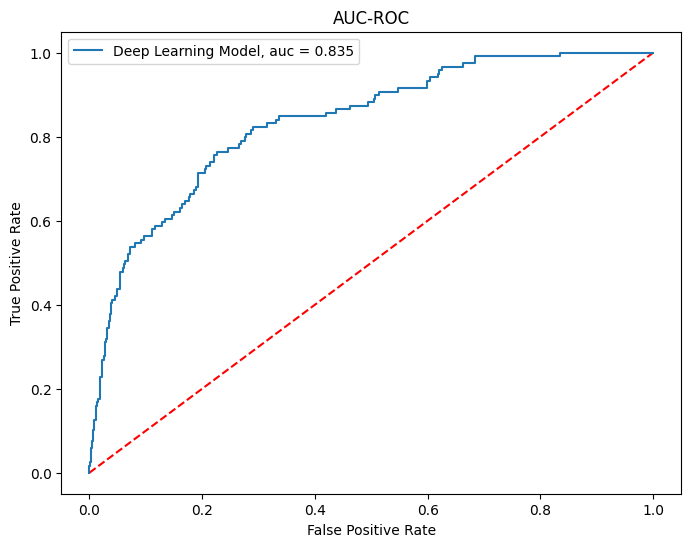

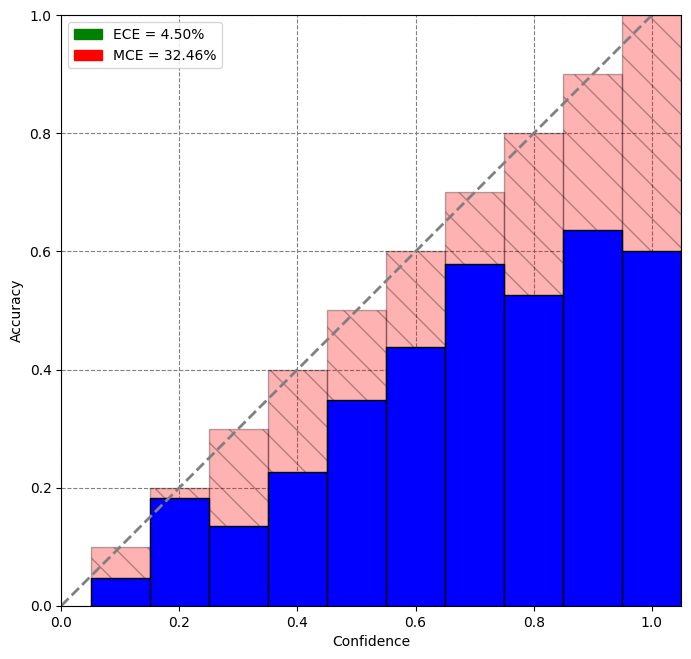

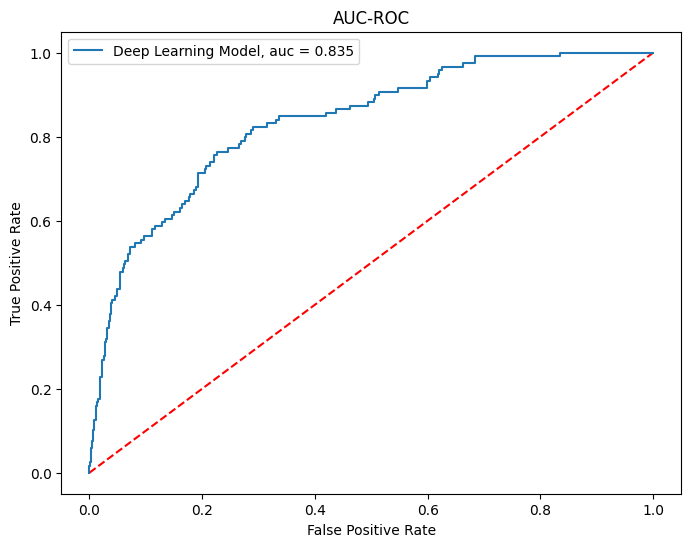

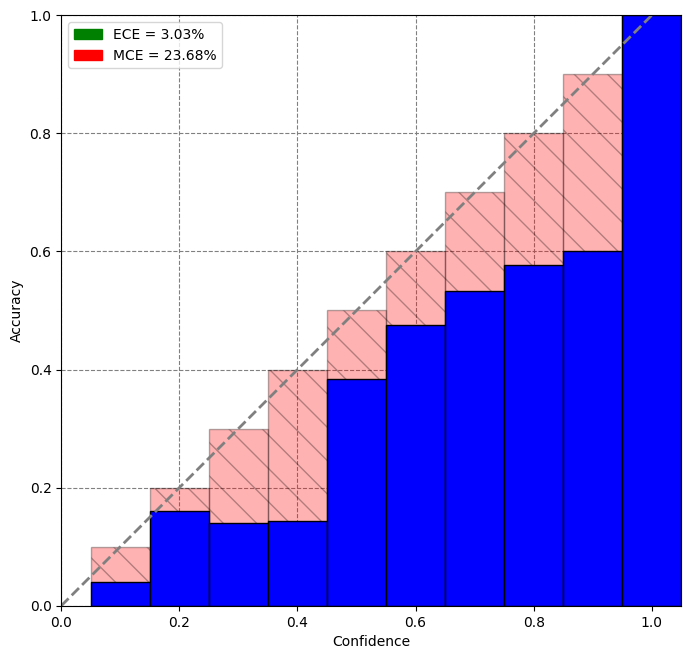

In [16]:
callibrate_output.callibrate(inputFile='outputDict_NODAB',outputFile='callibratedResults')